In [174]:
import requests
import json
import pandas as pd
import string
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")

To Do:

1. Combine notebooks into one final
2. Get data for prediction
3. EDA and finish notebook
4. Readme
5. Presentation
6. Technical Resume
7. Environment script

In [184]:
data.shape

(5646, 115)

In [3]:
# load data into notebook
data = pd.read_csv('data_ng')

### Explanation of Features

Do I need to do a full write-up in the notebook of all the features?

In [4]:
data.head()

,Unnamed: 0,Value,Length,AAV,Contract Age,Cap Hit,Position,Nationality,Height,Overall Pick,...,ixG_PLAYOFF_avg,xG±/60_PLAYOFF_avg,RelxG±/60_PLAYOFF_avg,C±/60_PLAYOFF_avg,RelC±/60_PLAYOFF_avg,G_PG_avg,P_PG_avg,PIM_PG_avg,G_PG_PLAYOFF_avg,P_PG_PLAYOFF_avg
0,2008,7500000.0,3.0,2500000.0,34.0,0.044092,L,USA,73.0,32.0,...,0.203333,-0.143333,-0.093333,-3.380000,-1.830000,0.167570,0.339205,0.233363,0.067340,0.215488
1,2011,600000.0,1.0,600000.0,37.0,0.009331,L,USA,73.0,32.0,...,0.310000,-0.080000,-0.055000,-3.365000,0.485000,0.079445,0.168506,0.139660,0.071429,0.071429
2,2012,600000.0,1.0,600000.0,38.0,0.010000,L,USA,73.0,32.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046526,0.110732,0.122208,0.000000,0.000000
3,2010,833334.0,1.0,833334.0,36.0,0.014029,L,USA,73.0,32.0,...,0.410000,-0.196667,-0.130000,-5.623333,-1.506667,0.127038,0.260485,0.228909,0.047619,0.047619
4,2005,1655130.0,1.0,1655130.0,30.0,0.042439,R,USA,73.0,35.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.235365,0.597847,0.822327,0.229167,0.575000


In [57]:
data.columns[1:40]

Index(['Value', 'Length', 'AAV', 'Contract Age', 'Cap Hit', 'Position',
       'Nationality', 'Height', 'Overall Pick', 'GAMES_PLAYED_t', 'G_t', 'A_t',
       'P_t', 'PLUS_MINUS_t', 'PIM_t', 'GP_PLAYOFF_t', 'G_PLAYOFF_t',
       'A_PLAYOFF_t', 'P_PLAYOFF_t', 'PLUS_MINUS_PLAYOFF_t', 'PIM_PLAYOFF_t',
       'TOI_t', 'ixG_t', 'xG±/60_t', 'RelxG±/60_t', 'C±/60_t', 'RelC±/60_t',
       'TOI_PLAYOFF_t', 'ixG_PLAYOFF_t', 'xG±/60_PLAYOFF_t',
       'RelxG±/60_PLAYOFF_t', 'C±/60_PLAYOFF_t', 'RelC±/60_PLAYOFF_t',
       'G_PG_t', 'P_PG_t', 'PIM_PG_t', 'G_PG_PLAYOFF_t', 'P_PG_PLAYOFF_t',
       'GAMES_PLAYED_t1'],
      dtype='object')

In [17]:
data.shape

(5646, 126)

First, we can look at how the player's position affects the year salary cap hit of his contract. In the positions we are examining in this project, players fall into two broad categories, defense ('D') and forwards ('F'). Forwards can further be broken down into centers ('C') and right ('R') and left ('L') wings.

In [7]:
# look at all forwards vs defense
data['Position_sub'] = data['Position'].apply(lambda x: 'D' if x == 'D' else 'F')

In [23]:
data['Position_sub'].value_counts()

F    3647
D    1999
Name: Position_sub, dtype: int64

<AxesSubplot: xlabel='Position', ylabel='Cap Hit'>

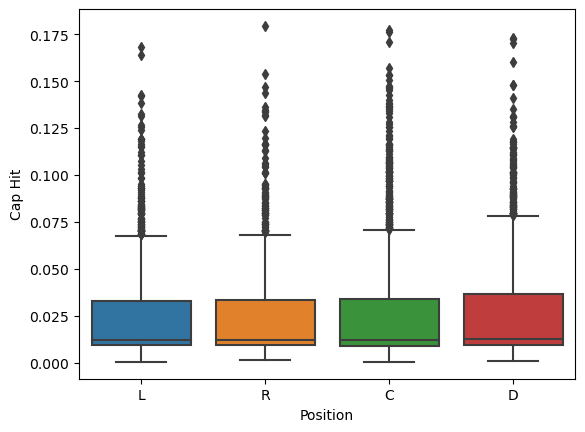

In [8]:
sns.boxplot(data=data,x='Position',y='Cap Hit')

<AxesSubplot: xlabel='Position_sub', ylabel='Cap Hit'>

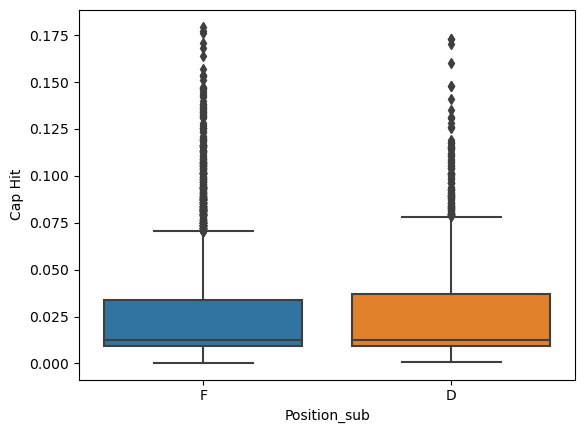

In [9]:
sns.boxplot(data=data,x='Position_sub',y='Cap Hit')

From the boxplots above, we can see that there is a slight distinction, though small, between forwards and defense, where it appears that the average metrics of defense contracts are slightly higher than those of forwards.

In [22]:
# look at number of players of each nationality
data['Nationality'].value_counts()

CAN    2948
USA    1512
SWE     356
CZE     222
FIN     171
RUS     146
SVK      69
CHE      52
DEU      38
DNK      30
LVA      20
FRA      14
AUT      13
BLR      13
NOR      11
UKR      10
LTU       6
POL       3
NLD       3
AUS       3
GBR       2
SVN       2
NGA       1
HRV       1
Name: Nationality, dtype: int64

<AxesSubplot: xlabel='Nationality', ylabel='Cap Hit'>

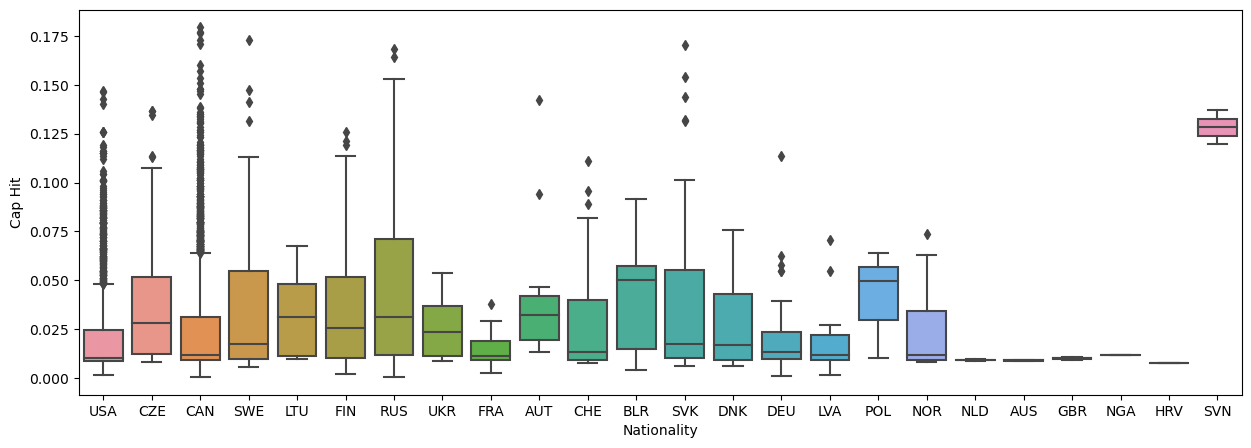

In [17]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(data=data,x='Nationality',y='Cap Hit',ax=ax)

Now looking at salary cap hit by player nationality, there is a lot more divergence, though we can draw a couple of interesting conclusions:
1. The USA and Canada, while have among the lowest median cap hits, also have by far the most outliers - this is likely a consequence of having by far the most players from these countries, and thus encompassing the largest range of salaries
2. Slovenia offered the highest median cap hit of all the countries included

<AxesSubplot: xlabel='Height', ylabel='Cap Hit'>

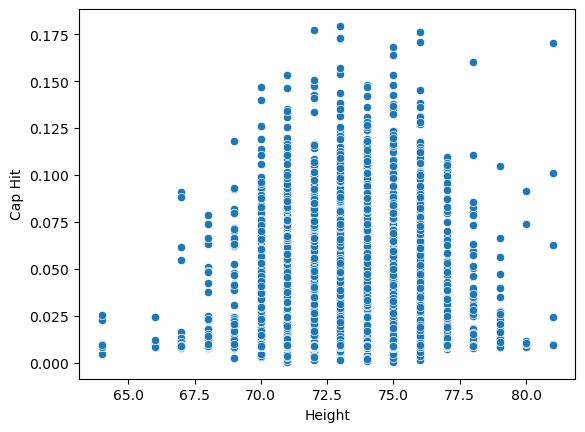

In [26]:
# look at salary cap vs height
sns.scatterplot(x=data['Height'],y=data['Cap Hit'])

While there is not an obvious relationship between salary cap hit and height, it does appear that shorter players tended to have lower cap hits, whereas taller players, who still had a range of cap hits, had more potential for higher salaries. Overall, however, this does not appear to be a strong driver of salary.

<AxesSubplot: xlabel='Overall Pick', ylabel='Cap Hit'>

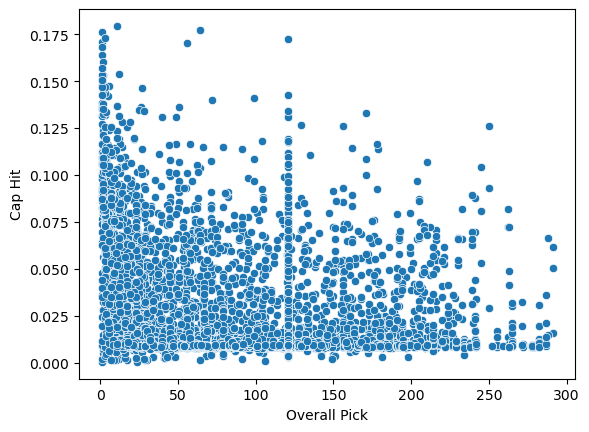

In [30]:
# look at salary cap vs draft pick
sns.scatterplot(x=data['Overall Pick'],y=data['Cap Hit'])

While draft pick is believed to be a strong indicator of potential player value, the above makes a different case; while there is clearly some trend of declining cap hit with increasing pick, there is also far more density of contracts with lower picks. This suggests that high overall pick might be less of an indicator of salary, and more of an indicator of success in the NHL to the extent that the point of salary negotiation becomes likely.

<AxesSubplot: xlabel='GAMES_PLAYED_avg', ylabel='Cap Hit'>

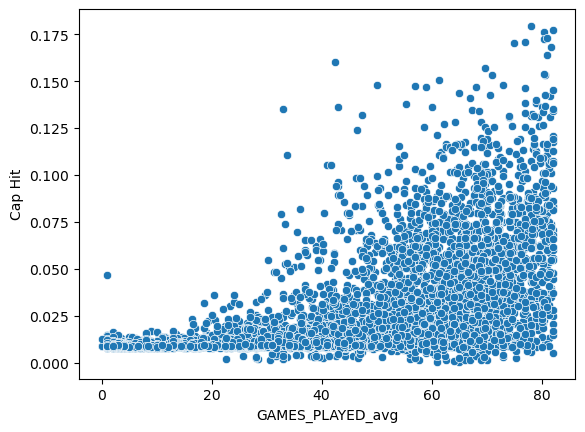

In [40]:
# look at salary cap vs draft pick
sns.scatterplot(x=data['GAMES_PLAYED_avg'],y=data['Cap Hit'])

Unsurprisingly, salary cap hit does increase quite a lot with games played; strong players are likely to be played in as many games as possible, rather than be healthy scratches, for example, and moreover, number of games played is a typical indicator of health (i.e. no injuries), which is also a positive signal in contract negotiations, because injured players present a risk to the value of a future contract.

KeyError: 'A_avg'

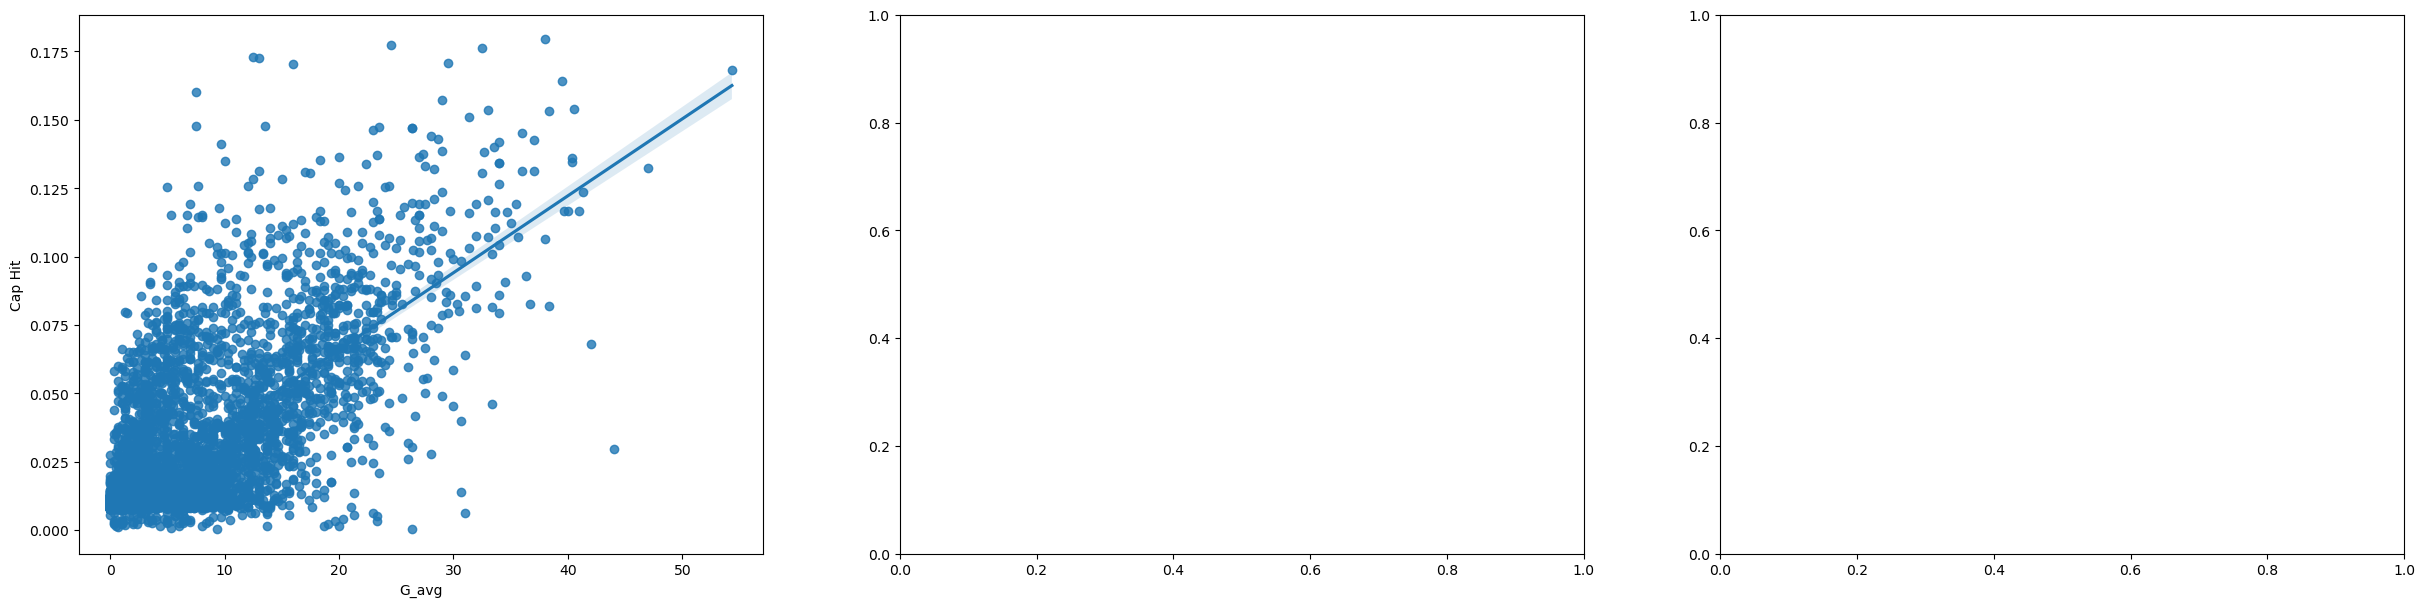

In [183]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,3,figsize=(30,7))
sns.regplot(x=data['G_avg'],y=data['Cap Hit'],ax=ax[0])
sns.regplot(x=data['A_avg'],y=data['Cap Hit'],ax=ax[1])
sns.regplot(x=data['P_avg'],y=data['Cap Hit'],ax=ax[2])

In one of the cleanest visuals yet, we can see that salary cap increases with goals, assists, and points (the sum of goals and assists). The relationship is slightly stronger in assists and points, most likely because assists typically make up a larger portion of a players point total, as multiple players can have an assist on a goal. 

<AxesSubplot: xlabel='PLUS_MINUS_avg', ylabel='Cap Hit'>

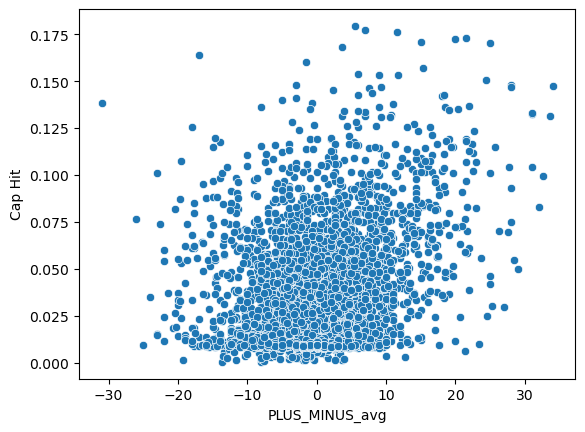

In [51]:
# look at salary cap vs draft pick
sns.scatterplot(x=data['PLUS_MINUS_avg'],y=data['Cap Hit'])

Alternatively, there is a much less clear relationship between salary cap and plus-minus, which is a metric meant to encapsulate a player's offensive and defensive skill. Though the plot hardly offers room for a firm conclusion, given the strength of the relationship between points and salary cap, there is already some sense that it is the offensive production of a player, regardless of position, that is a stronger indicator of payment, rather than the ability to balance offensive and defensive responsibilities. 

<AxesSubplot: xlabel='TOI_avg', ylabel='Cap Hit'>

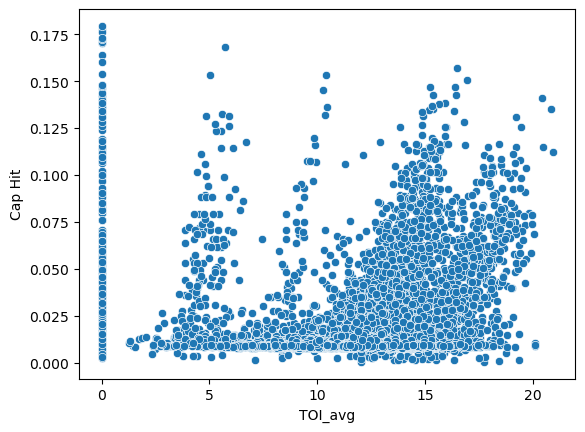

In [60]:
# look at salary cap vs draft pick
sns.scatterplot(x=data['TOI_avg'],y=data['Cap Hit'])

Penalty minutes is yet another metric that offers and unclear picture.

In [181]:
data[data['TOI_avg'] == 0]

,Length,Contract Age,Cap Hit,Position,Nationality,Height,Overall Pick,GAMES_PLAYED_t,G_t,P_t,...,ixG_PLAYOFF_avg,xG±/60_PLAYOFF_avg,RelxG±/60_PLAYOFF_avg,C±/60_PLAYOFF_avg,RelC±/60_PLAYOFF_avg,G_PG_avg,P_PG_avg,PIM_PG_avg,G_PG_PLAYOFF_avg,P_PG_PLAYOFF_avg
4,1.0,30.0,0.042439,R,USA,73.0,35.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.235365,0.597847,0.822327,0.229167,0.575000
5,5.0,31.0,0.063636,R,USA,73.0,35.0,80.0,19.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.213090,0.576533,0.868160,0.166667,0.922222
8,1.0,29.0,0.107179,C,CZE,73.0,51.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.404547,0.845754,0.404095,0.404167,0.770833
9,7.0,30.0,0.136364,C,CZE,73.0,51.0,38.0,16.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.442234,1.086008,0.531451,0.633333,1.388889
11,3.0,31.0,0.031146,D,CAN,73.0,90.0,75.0,4.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.035439,0.194035,0.520702,0.000000,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5490,3.0,30.0,0.031809,D,CAN,71.0,121.0,23.0,4.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.125418,0.396878,1.243868,0.000000,0.000000
5523,1.0,23.0,0.020511,C,FIN,75.0,6.0,64.0,6.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.093750,0.328125,0.625000,0.000000,0.000000
5524,4.0,24.0,0.064612,C,FIN,75.0,6.0,82.0,20.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.168826,0.493331,0.666159,0.100000,0.100000
5563,2.0,25.0,0.015408,C,USA,72.0,30.0,74.0,5.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.104206,0.269223,0.742863,0.000000,0.000000


# Model Pre-processing

Before we can start building linear models, we need to do some data pre-processing. This process will do two things: encode categorical variables so that they can be included in the models, and scale numerical values to make sure they are being appropriately handled.

## Encode Categorical Variables

In [63]:
data = data.drop(columns=['Unnamed: 0','Value','AAV','Position_sub','A_t','A_PLAYOFF_t','A_t1','A_PLAYOFF_t1','A_t2','A_PLAYOFF_t2','A_avg','A_PLAYOFF_avg'])
y = data['Cap Hit']
y_l = data['Length']
X = data.drop(columns=['Cap Hit','Length'],axis=1)

In [64]:
# split data into categorical variables
categorical_variables = ['Position','Nationality']
X_categorical = X[categorical_variables]
X_numeric = X.drop(columns=categorical_variables,axis=1)

In [65]:
ohe = OneHotEncoder(sparse=False)
x_categorical = ohe.fit_transform(X_categorical)

In [66]:
X_categorical = pd.DataFrame(x_categorical,columns=ohe.get_feature_names_out())

In [67]:
scaler = StandardScaler()
x = scaler.fit_transform(X_numeric)
X_numeric = pd.DataFrame(x,columns=X_numeric.columns)
X = pd.concat([X_numeric,X_categorical],axis=1)

In [68]:
X.head()

,Contract Age,Height,Overall Pick,GAMES_PLAYED_t,G_t,P_t,PLUS_MINUS_t,PIM_t,GP_PLAYOFF_t,G_PLAYOFF_t,...,Nationality_NGA,Nationality_NLD,Nationality_NOR,Nationality_POL,Nationality_RUS,Nationality_SVK,Nationality_SVN,Nationality_SWE,Nationality_UKR,Nationality_USA
0,1.774732,-0.073823,-0.868658,0.473323,0.765433,0.443237,1.152867,-0.077922,0.377966,-0.330044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.553458,-0.073823,-0.868658,-1.360610,-0.740844,-0.839117,0.013959,-0.839916,-0.533297,-0.330044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.813034,-0.073823,-0.868658,0.745016,-0.615321,-0.678823,-1.580512,-0.562827,-0.533297,-0.330044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.293883,-0.073823,-0.868658,0.405399,-0.238752,-0.358235,-1.124949,-0.632099,-0.533297,-0.330044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.736429,-0.073823,-0.821304,-1.360610,-0.740844,-0.839117,0.013959,-0.839916,-0.533297,-0.330044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modelling

NHL player contracts are defined by two aspects: yearly value, or the cap hit, and the number of years over which the payout will occur. Rather than model the total value of the contract, which will have some trend effect due to the nature of the salary cap and projections of where it is going, we can model the contract as separate parts, trying to predict both the salary cap hit and the term of the contract from the same data.

## Cap Hit Prediction

### Ridge Regression

For both Ridge Regression and LASSO, we can use cross-validation to fit model parameters. To do so, we will split the data into a training set and a test set, and then perform cross-validation on the training set. This allows us to hold some data back so that we can establish an unbiased metric for the final model on the same set of data. 

In [220]:
ridge = linear_model.Ridge()
ridge_parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1))),
                    'positive': [True,False],
                    'fit_intercept': [False]}

In [221]:
gs_ridge = GridSearchCV(ridge,ridge_parameters,scoring='neg_mean_absolute_error',cv=5)

In [222]:
gs_ridge.fit(X,y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. , 12. ,
       13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. ,
       24. ]),
                         'fit_intercept': [False], 'positive': [True, False]},
             scoring='neg_mean_absolute_error')

In [223]:
gs_ridge.best_params_

{'alpha': 21.0, 'fit_intercept': False, 'positive': False}

In [224]:
gs_ridge.best_score_

-0.009351321254922315

In [225]:
ridge_final = linear_model.Ridge(alpha = 21,fit_intercept=False,positive=False)

ridge_final.fit(X,y)

Ridge(alpha=21, fit_intercept=False)

In [226]:
coefficients = pd.DataFrame(ridge_final.coef_).T
coefficients.names = list(ridge_final.feature_names_in_)

/var/folders/33/b9z3l98x2r3fz5kyh065tz7c0000gn/T/ipykernel_50370/3756197642.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  coefficients.names = list(ridge_final.feature_names_in_)


In [227]:
ridge_coef = pd.DataFrame(pd.Series(ridge_final.coef_,index=ridge_final.feature_names_in_))

In [228]:
abs(ridge_coef).sort_values(by=0,ascending=False).head(20)

,0
Position_D,0.024655
Position_C,0.017877
Position_L,0.017696
Position_R,0.016358
P_avg,0.013687
Nationality_RUS,0.010641
P_t,0.010092
Nationality_SWE,0.006726
Nationality_USA,0.006667
Nationality_SVK,0.006526


### LASSO

In [229]:
lasso = linear_model.Lasso()
lasso_parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.01), np.arange(2, 5, 0.5), np.arange(5, 25, 1))),
                    'positive': [True,False],
                    'fit_intercept': [False]}

In [230]:
lasso_ridge = GridSearchCV(lasso,lasso_parameters,scoring='neg_mean_absolute_error',cv=5)
lasso_ridge.fit(X,y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00e-02, 2.00e-02, 3.00e-02, 4.00e-02, 5.00e-02, 6.00e-02,
       7.00e-02, 8.00e-02, 9.00e-02, 1.00e-01, 1.10e-01, 1.20e-01,
       1.30e-01, 1.40e-01, 1.50e-01, 1.60e-01, 1.70e-01, 1.80e-01,
       1.90e-01, 2.00e-01, 2.10e-01, 2.20e-01, 2.30e-01, 2.40e-01,
       2.50e-01, 2.60e-01, 2.70e-01, 2.80e-01, 2.90e-01, 3.00e-01,
       3.10e-01, 3.20e-01...
       1.93e+00, 1.94e+00, 1.95e+00, 1.96e+00, 1.97e+00, 1.98e+00,
       1.99e+00, 2.00e+00, 2.50e+00, 3.00e+00, 3.50e+00, 4.00e+00,
       4.50e+00, 5.00e+00, 6.00e+00, 7.00e+00, 8.00e+00, 9.00e+00,
       1.00e+01, 1.10e+01, 1.20e+01, 1.30e+01, 1.40e+01, 1.50e+01,
       1.60e+01, 1.70e+01, 1.80e+01, 1.90e+01, 2.00e+01, 2.10e+01,
       2.20e+01, 2.30e+01, 2.40e+01]),
                         'fit_intercept': [False], 'positive': [True, False]},
             scoring='neg_mean_absolute_error')

In [231]:
lasso_ridge.best_params_

{'alpha': 0.01, 'fit_intercept': False, 'positive': True}

In [232]:
lasso_ridge.best_score_

-0.023464403349474392

In [233]:
lasso_final = linear_model.Lasso(alpha = 0.01,fit_intercept=False,positive=True)
lasso_final.fit(X,y)

Lasso(alpha=0.01, fit_intercept=False, positive=True)

In [234]:
lasso_coef = pd.DataFrame(pd.Series(lasso_final.coef_,index=lasso_final.feature_names_in_))

In [235]:
abs(lasso_coef).sort_values(by=0,ascending=False).head(20)

,0
P_avg,0.012627
Nationality_CAN,0.006500
Contract Age,0.000000
PIM_avg,0.000000
G_PLAYOFF_avg,0.000000
P_PLAYOFF_avg,0.000000
PLUS_MINUS_PLAYOFF_avg,0.000000
PIM_PLAYOFF_avg,0.000000
TOI_avg,0.000000
ixG_avg,0.000000


### Elastic Net

In [236]:
eln = linear_model.ElasticNet()
eln_parameters = {'alpha': np.arange(0,1,0.005),
                  'fit_intercept': [False]}

In [237]:
gs_eln = GridSearchCV(eln,eln_parameters,scoring='neg_mean_absolute_error',cv=5)
gs_eln.fit(X,y)

/Users/Amelia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/Amelia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/Amelia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.723e-01, tolerance: 6.560e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255,...
       0.72 , 0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 ,
       0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805,
       0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 ,
       0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895,
       0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995]),
                         'fit_intercept': [False]},
             scoring='neg_mean_absolute_error')

In [238]:
gs_eln.best_score_

-0.009419616094536367

In [239]:
gs_eln.best_params_

{'alpha': 0.0, 'fit_intercept': False}

In [240]:
eln_final = linear_model.ElasticNet(alpha = 0.0,fit_intercept=False)
eln_final.fit(X,y)

/var/folders/33/b9z3l98x2r3fz5kyh065tz7c0000gn/T/ipykernel_50370/3108468750.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  eln_final.fit(X,y)
/Users/Amelia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/Amelia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.972e-01, tolerance: 8.201e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/Ridge

ElasticNet(alpha=0.0, fit_intercept=False)

In [272]:
eln_coef = pd.DataFrame(pd.Series(eln_final.coef_,index=eln_final.feature_names_in_))

In [273]:
abs(eln_coef).sort_values(by=0,ascending=False).head(20)

,0
Position_D,0.031052
Nationality_SVN,0.024377
Position_C,0.024314
Position_L,0.024150
Position_R,0.022851
P_avg,0.014477
P_t,0.011310
Nationality_NGA,0.009738
Nationality_POL,0.009132
Nationality_GBR,0.007405


In [291]:
eln_pred = eln_final.predict(X)

In [292]:
mean_absolute_error(eln_pred,y)

0.00901353310817257

<AxesSubplot: xlabel='Cap Hit'>

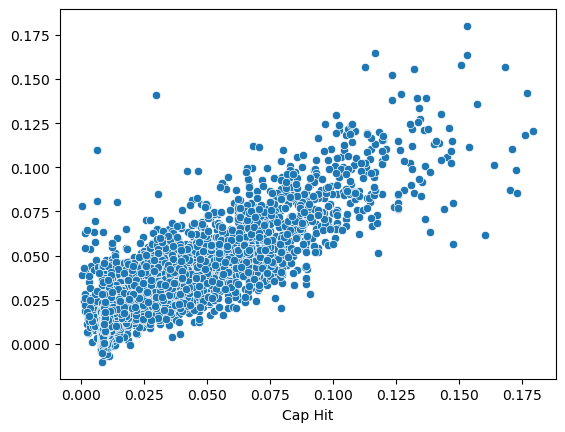

In [299]:
sns.scatterplot(x=y,y=eln_pred)

### Decision Tree Regression

In [268]:
dtr = DecisionTreeRegressor(random_state=42)
dtr_parameters_1 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                    'splitter': ['best','random'],
                    'max_depth':[1,5,10,20],
                    'min_samples_split':[1,3,5,7],
                    'max_features':['auto','sqrt','log2']}

In [258]:
gs_dtr_1 = GridSearchCV(dtr,dtr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)

In [261]:
gs_dtr_1.fit(X,y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5, 7],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=False)

In [262]:
gs_dtr_1.best_score_

-0.008269567724629754

In [263]:
gs_dtr_1.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 1,
 'splitter': 'best'}

In [265]:
dtr_parameters_2 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                    'splitter': ['best','random'],
                    'max_depth':[2,5,9],
                    'min_samples_split':[1,2,3],
                    'max_features':['auto','sqrt','log2']}
gs_dtr_2 = GridSearchCV(dtr,dtr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_2.fit(X,y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 5, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 2, 3],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=False)

In [266]:
gs_dtr_2.best_score_

-0.008274989991656797

In [267]:
gs_dtr_2.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 3,
 'splitter': 'best'}

In [46]:
dtr_final = DecisionTreeRegressor(criterion = 'absolute_error',
                                  splitter = 'best',
                                  max_features = 'auto',
                                  max_depth = 5,
                                  min_samples_split = 3)
dtr_final.fit(X,y)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features='auto', min_samples_split=3)

In [276]:
dtr_featureImportances = pd.DataFrame(pd.Series(dtr_final.feature_importances_,index=dtr_final.feature_names_in_))

In [284]:
dtr_featureImportances[dtr_featureImportances[0] > 0].sort_values(by=0,ascending=False)

,0
P_avg,0.542140
P_PG_avg,0.144076
P_t,0.116384
TOI_t,0.104740
P_PG_t,0.026668
Contract Age,0.022457
Position_D,0.012447
GAMES_PLAYED_avg,0.011784
RelC±/60_avg,0.003677
PLUS_MINUS_t2,0.003333


In [47]:
y_pred = dtr_final.predict(X)

In [48]:
mean_absolute_error(y_pred,y)

0.007064606687005003

<AxesSubplot: xlabel='Cap Hit'>

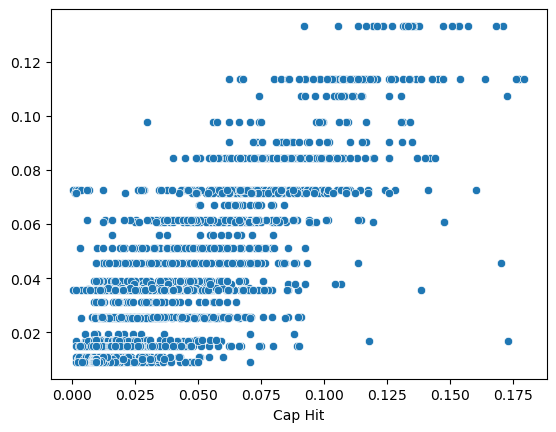

In [293]:
sns.scatterplot(x=y,y=y_pred)

In [28]:
xgbr = XGBRegressor(random_state=42)
xgbr_parameters_1 = {'learning_rate': [0.05, 0.10, 0.15],
                     'max_depth': [2,5,10],
                     'min_child_weight': [1,3,5],
                     'n_estimators': [20,40,80],
                     'tree_method': ['exact','approx','hist']}

In [29]:
gs_xgbr_1 = GridSearchCV(xgbr,xgbr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_1.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [20, 40, 80],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error', verbose=False)

In [30]:
gs_xgbr_1.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 80,
 'tree_method': 'exact'}

In [31]:
xgbr_parameters_2 = {'learning_rate': [0.05, 0.10, 0.15],
                     'max_depth': [5,10,20],
                     'min_child_weight': [3,5,10],
                     'n_estimators': [40,80,100],
                     'tree_method': ['exact','approx','hist']}

In [32]:
gs_xgbr_2 = GridSearchCV(xgbr,xgbr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_2.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [5, 10, 20],
                         'min_child_weight': [3, 5, 10],
                         'n_estimators': [40, 80, 100],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error', verbose=False)

In [33]:
gs_xgbr_2.best_params_

{'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_weight': 10,
 'n_estimators': 100,
 'tree_method': 'exact'}

In [35]:
xgb_default = XGBRegressor(random_state=42)
xgb_default.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [40]:
xgb_default_pred = xgb_default.predict(X)

In [43]:
mean_absolute_error(xgb_default_pred,y)

0.0015342118364013472

In [55]:
xgb_default_featureImportances = pd.DataFrame(pd.Series(xgb_default.feature_importances_,index=xgb_default.feature_names_in_))

In [58]:
xgb_default_featureImportances[xgb_default_featureImportances[0] != 0].sort_values(by=0,ascending=False)

,0
P_avg,0.378899
P_t,0.060313
Position_D,0.056393
P_PG_avg,0.036803
P_PG_t,0.033002
...,...
RelC±/60_PLAYOFF_t2,0.000645
G_PLAYOFF_t2,0.000386
Nationality_FRA,0.000331
Nationality_AUT,0.000259


<AxesSubplot: ylabel='0'>

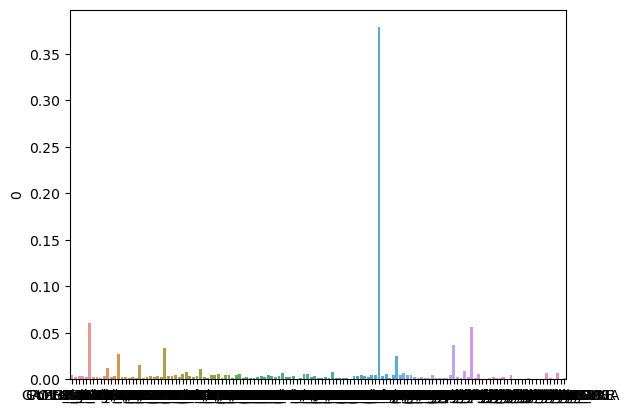

In [61]:
sns.barplot(x=xgb_default_featureImportances.index,y=xgb_default_featureImportances[0])

In [64]:
xgbr_parameters_3 = {'learning_rate': [0.10],
                     'max_depth': [10,20,40],
                     'min_child_weight': [5,10,20],
                     'n_estimators': [80,100,120],
                     'tree_method': ['exact','approx','hist']}

In [65]:
gs_xgbr_3 = GridSearchCV(xgbr,xgbr_parameters_3,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_3.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [10, 20, 40],
                         'min_child_weight': [5, 10, 20],
                         'n_estimators': [80, 100, 120],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error', verbose=False)

In [66]:
gs_xgbr_3.best_params_

{'learning_rate': 0.1,
 'max_depth': 40,
 'min_child_weight': 10,
 'n_estimators': 100,
 'tree_method': 'exact'}

In [67]:
xgbr_parameters_4 = {'learning_rate': [0.10],
                     'max_depth': [20,40,60],
                     'min_child_weight': [5,10,15],
                     'n_estimators': [85,100,115],
                     'tree_method': ['exact']}

In [68]:
gs_xgbr_4 = GridSearchCV(xgbr,xgbr_parameters_4,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_4.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [20, 40, 60],
                         'min_child_weight': [5, 10, 15],
                         'n_estimators': [85, 100, 115],
                         'tree_method': ['exact']},
             scoring='neg_mean_absolute_error', verbose=False)

In [69]:
gs_xgbr_4.best_params_

{'learning_rate': 0.1,
 'max_depth': 40,
 'min_child_weight': 10,
 'n_estimators': 85,
 'tree_method': 'exact'}

In [70]:
xgbr_parameters_5 = {'learning_rate': [0.10],
                     'max_depth': [30,40,50],
                     'min_child_weight': [8,10,12],
                     'n_estimators': [75,85,100],
                     'tree_method': ['exact']}

In [71]:
gs_xgbr_5 = GridSearchCV(xgbr,xgbr_parameters_5,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_5.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [30, 40, 50],
                         'min_child_weight': [8, 10, 12],
                         'n_estimators': [75, 85, 100],
                         'tree_method': ['exact']},
             scoring='neg_mean_absolute_error', verbose=False)

In [72]:
gs_xgbr_5.best_params_

{'learning_rate': 0.1,
 'max_depth': 30,
 'min_child_weight': 10,
 'n_estimators': 85,
 'tree_method': 'exact'}

In [73]:
xgbr_parameters_6 = {'learning_rate': [0.10],
                     'max_depth': [25,30,35,40],
                     'min_child_weight': [8,10,12],
                     'n_estimators': [75,85,95],
                     'tree_method': ['exact']}

In [74]:
gs_xgbr_6 = GridSearchCV(xgbr,xgbr_parameters_6,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_6.fit(X,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [25, 30, 35, 40],
                         'min_child_weight': [8, 10, 12],
                         'n_estimators': [75, 85, 95],
                         'tree_method': ['exact']},
             scoring='neg_mean_absolute_error', verbose=False)

In [75]:
gs_xgbr_6.best_params_

{'learning_rate': 0.1,
 'max_depth': 30,
 'min_child_weight': 10,
 'n_estimators': 85,
 'tree_method': 'exact'}

In [77]:
xgbr_final = XGBRegressor(learning_rate = 0.1,
                          max_depth = 30,
                          min_child_weight = 10,
                          n_estimators = 85,
                          tree_method = 'exact',
                          random_state = 42)
xgbr_final.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=85, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [78]:
xgbr_final_pred = xgbr_final.predict(X)

In [79]:
mean_absolute_error(xgbr_final_pred,y)

0.0008336468119178603

In [85]:
0.0008336468119178603*82500000

68775.86198322347

Question - if you are using MSE on scaled data, does that change the interpretation? Figure out real meaning of this

In [80]:
xgb_final_featureImportances = pd.DataFrame(pd.Series(xgbr_final.feature_importances_,index=xgbr_final.feature_names_in_))

In [83]:
xgb_final_featureImportances[xgb_final_featureImportances[0] != 0].sort_values(by=0,ascending=False)

,0
P_avg,0.357194
P_t,0.084693
P_PG_t,0.053228
Position_D,0.051100
P_PLAYOFF_avg,0.040439
...,...
Nationality_DEU,0.001087
ixG_PLAYOFF_t,0.001040
C±/60_PLAYOFF_avg,0.001012
Nationality_CZE,0.000706


## Contract Term

### Ridge Regression

In [75]:
ridge_l = linear_model.Ridge()
ridge_parameters_l = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1))),
                      'positive': [True,False],
                      'fit_intercept': [False]}

In [93]:
gs_ridge_l = GridSearchCV(ridge_l,ridge_parameters_l,cv=5,scoring='neg_mean_absolute_error')
gs_ridge_l.fit(X,y_l)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. , 12. ,
       13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. ,
       24. ]),
                         'fit_intercept': [False], 'positive': [True, False]},
             scoring='neg_mean_absolute_error')

In [94]:
gs_ridge_l.best_score_

-0.883971281434674

In [95]:
gs_ridge_l.best_params_

{'alpha': 24.0, 'fit_intercept': False, 'positive': False}

In [96]:
# fit final model
ridge_l_final = linear_model.Ridge(alpha=14,fit_intercept=False,positive=False)
ridge_l_final.fit(X,y_l)

Ridge(alpha=14, fit_intercept=False)

In [97]:
# get in-sample MAE
mean_absolute_error(ridge_l_final.predict(X),y_l)

0.8578746769399919

A real-life interpretation for this part of the model would be that the best ridge regression is off by about 1 year - not ideal considering the average length of contracts.

In [128]:
ridge_l_coef = pd.DataFrame(pd.Series(ridge_l_final.coef_,index=ridge_l_final.feature_names_in_)).sort_values(by=0,ascending=False)

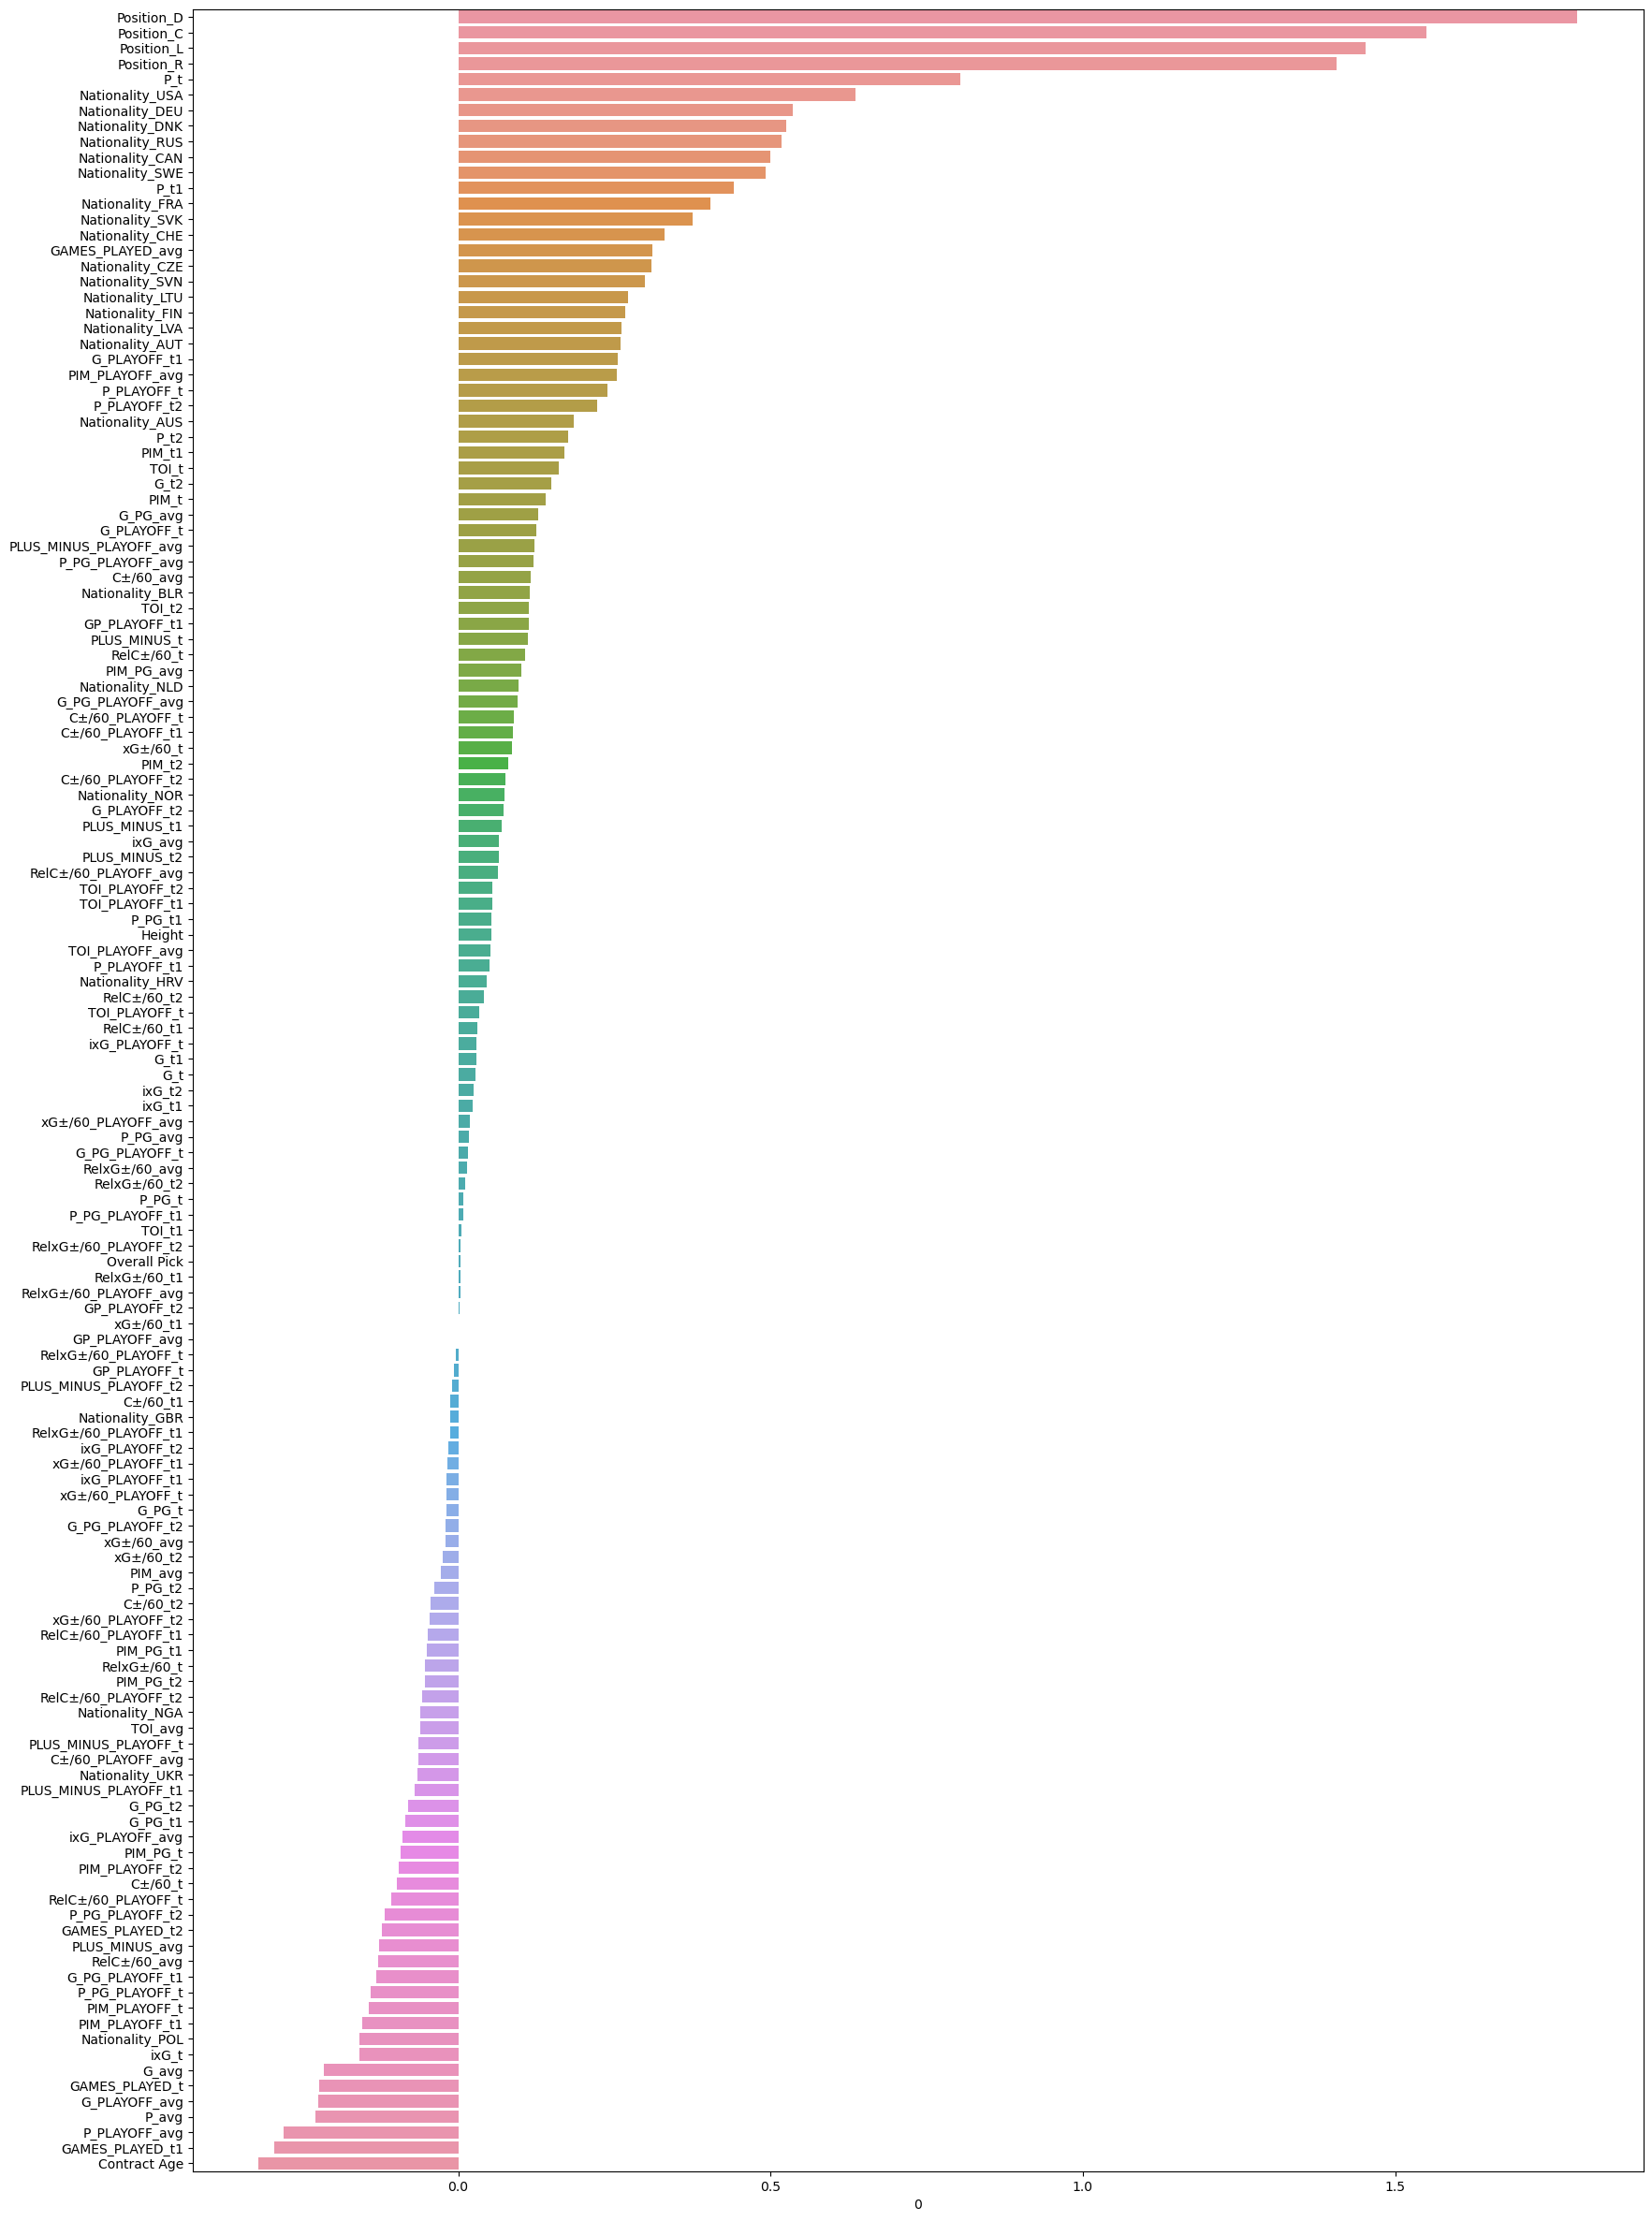

In [129]:
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=ridge_l_coef.index,x=ridge_l_coef[0]);

When it comes to modeling contract term, the ridge regression model seems to have emphasis on player position as well as nationality, the latter of which would not be anticipated to be much of a factor. Other variables interspersed are point totals and games played, which make more sense fundamentally as well.

### LASSO

In [90]:
# initialize lasso model and parameters
lasso_l = linear_model.Lasso()
lasso_l_parameters = {'alpha': np.concatenate((np.arange(0.01,2,0.01), np.arange(2, 5, 0.5), np.arange(5, 25, 1))),
                      'positive': [True,False],
                      'fit_intercept': [False]}
gs_lasso_l = GridSearchCV(lasso_l,lasso_l_parameters,scoring='neg_mean_absolute_error',cv=5)
gs_lasso_l.fit(X,y_l)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00e-02, 2.00e-02, 3.00e-02, 4.00e-02, 5.00e-02, 6.00e-02,
       7.00e-02, 8.00e-02, 9.00e-02, 1.00e-01, 1.10e-01, 1.20e-01,
       1.30e-01, 1.40e-01, 1.50e-01, 1.60e-01, 1.70e-01, 1.80e-01,
       1.90e-01, 2.00e-01, 2.10e-01, 2.20e-01, 2.30e-01, 2.40e-01,
       2.50e-01, 2.60e-01, 2.70e-01, 2.80e-01, 2.90e-01, 3.00e-01,
       3.10e-01, 3.20e-01...
       1.93e+00, 1.94e+00, 1.95e+00, 1.96e+00, 1.97e+00, 1.98e+00,
       1.99e+00, 2.00e+00, 2.50e+00, 3.00e+00, 3.50e+00, 4.00e+00,
       4.50e+00, 5.00e+00, 6.00e+00, 7.00e+00, 8.00e+00, 9.00e+00,
       1.00e+01, 1.10e+01, 1.20e+01, 1.30e+01, 1.40e+01, 1.50e+01,
       1.60e+01, 1.70e+01, 1.80e+01, 1.90e+01, 2.00e+01, 2.10e+01,
       2.20e+01, 2.30e+01, 2.40e+01]),
                         'fit_intercept': [False], 'positive': [True, False]},
             scoring='neg_mean_absolute_error')

In [91]:
# best parameters
gs_lasso_l.best_params_

{'alpha': 0.01, 'fit_intercept': False, 'positive': False}

In [92]:
# best score
gs_lasso_l.best_score_

-0.876979584515419

In [98]:
# initialize model with best parameters
lasso_l_final = linear_model.Lasso(alpha=0.01,fit_intercept=False,positive=False)
lasso_l_final.fit(X,y_l)

Lasso(alpha=0.01, fit_intercept=False)

In [99]:
mean_absolute_error(lasso_l_final.predict(X),y_l)

0.8640259600397503

In [122]:
lasso_l_final_coef = pd.DataFrame(pd.Series(lasso_l_final.coef_,index=lasso_l_final.feature_names_in_))
lasso_l_final_coef_sub = lasso_l_final_coef[lasso_l_final_coef[0] != 0].sort_values(by=0,ascending=False)

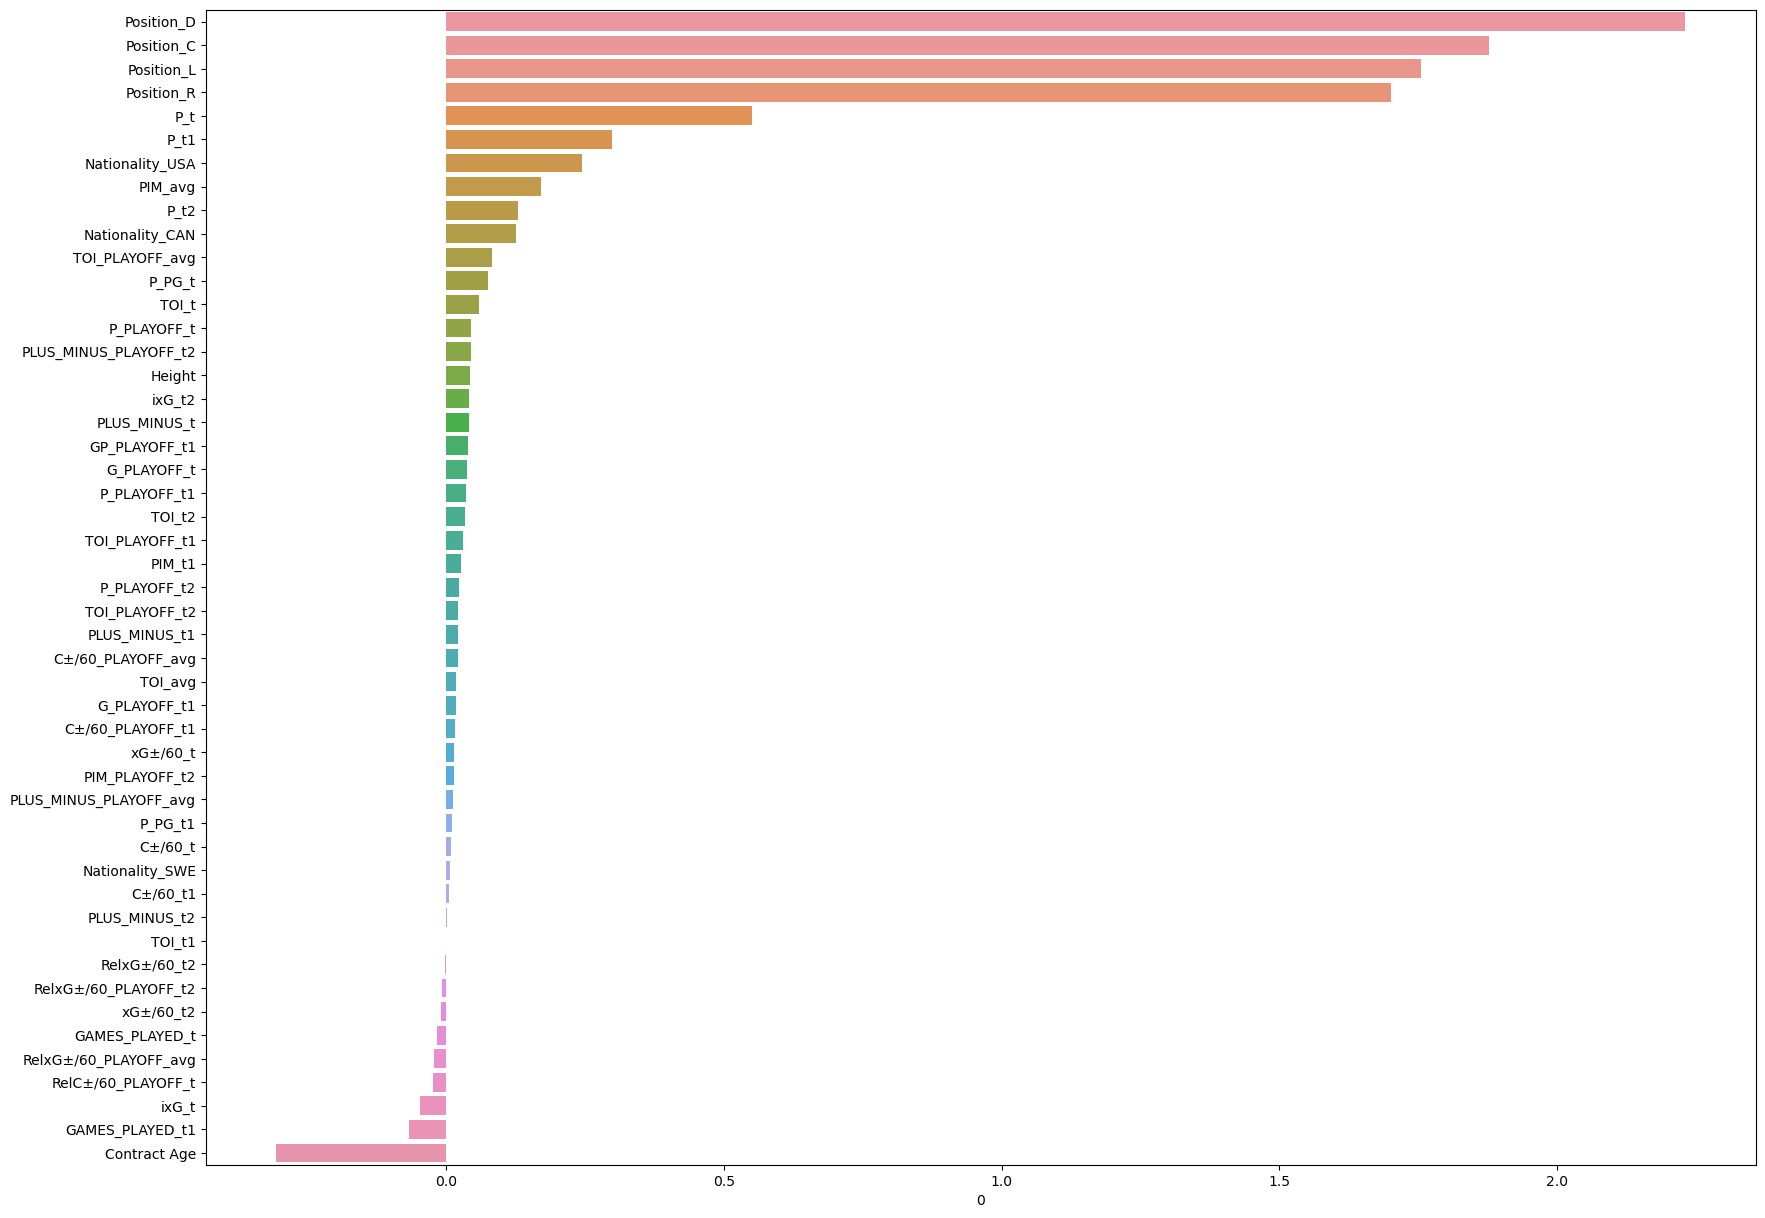

In [125]:
fig,ax = plt.subplots(figsize=(20,15))
sns.barplot(y=lasso_l_final_coef_sub.index,x=lasso_l_final_coef_sub[0]);

As expected when using LASSO, we see similar variables as are in ridge show up as important, but with the added benefit that rather unimportant features have been filtered out. This has the effect of helping us narrow what features are prominent in modeling contract term; namely contract age, points in the contract year, point history, and position (specifically defense).

### Elastic Net

In [111]:
eln_l = linear_model.ElasticNet()
eln_l_parameters = {'alpha': np.arange(0,1,0.005),
                    'fit_intercept': [False]}
gs_eln_l = GridSearchCV(eln_l,eln_l_parameters,cv=5,scoring='neg_mean_absolute_error')
gs_eln_l.fit(X,y_l)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255,...
       0.72 , 0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 ,
       0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805,
       0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 ,
       0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895,
       0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995]),
                         'fit_intercept': [False]},
             scoring='neg_mean_absolute_error')

In [112]:
gs_eln_l.best_score_

-0.880834568558153

In [113]:
gs_eln_l.best_params_

{'alpha': 0.01, 'fit_intercept': False}

In [114]:
# initialize best model
eln_l_final = linear_model.ElasticNet(alpha=0.01,fit_intercept=False)
eln_l_final.fit(X,y_l)

ElasticNet(alpha=0.01, fit_intercept=False)

In [115]:
# get in-sample score
mean_absolute_error(eln_l_final.predict(X),y_l)

0.8636622223549961

In [126]:
# get coefficients
eln_l_coef = pd.DataFrame(pd.Series(eln_l_final.coef_,index=eln_l_final.feature_names_in_))
eln_l_coef_sub = eln_l_coef[eln_l_coef[0] != 0].sort_values(by=0,ascending=False)

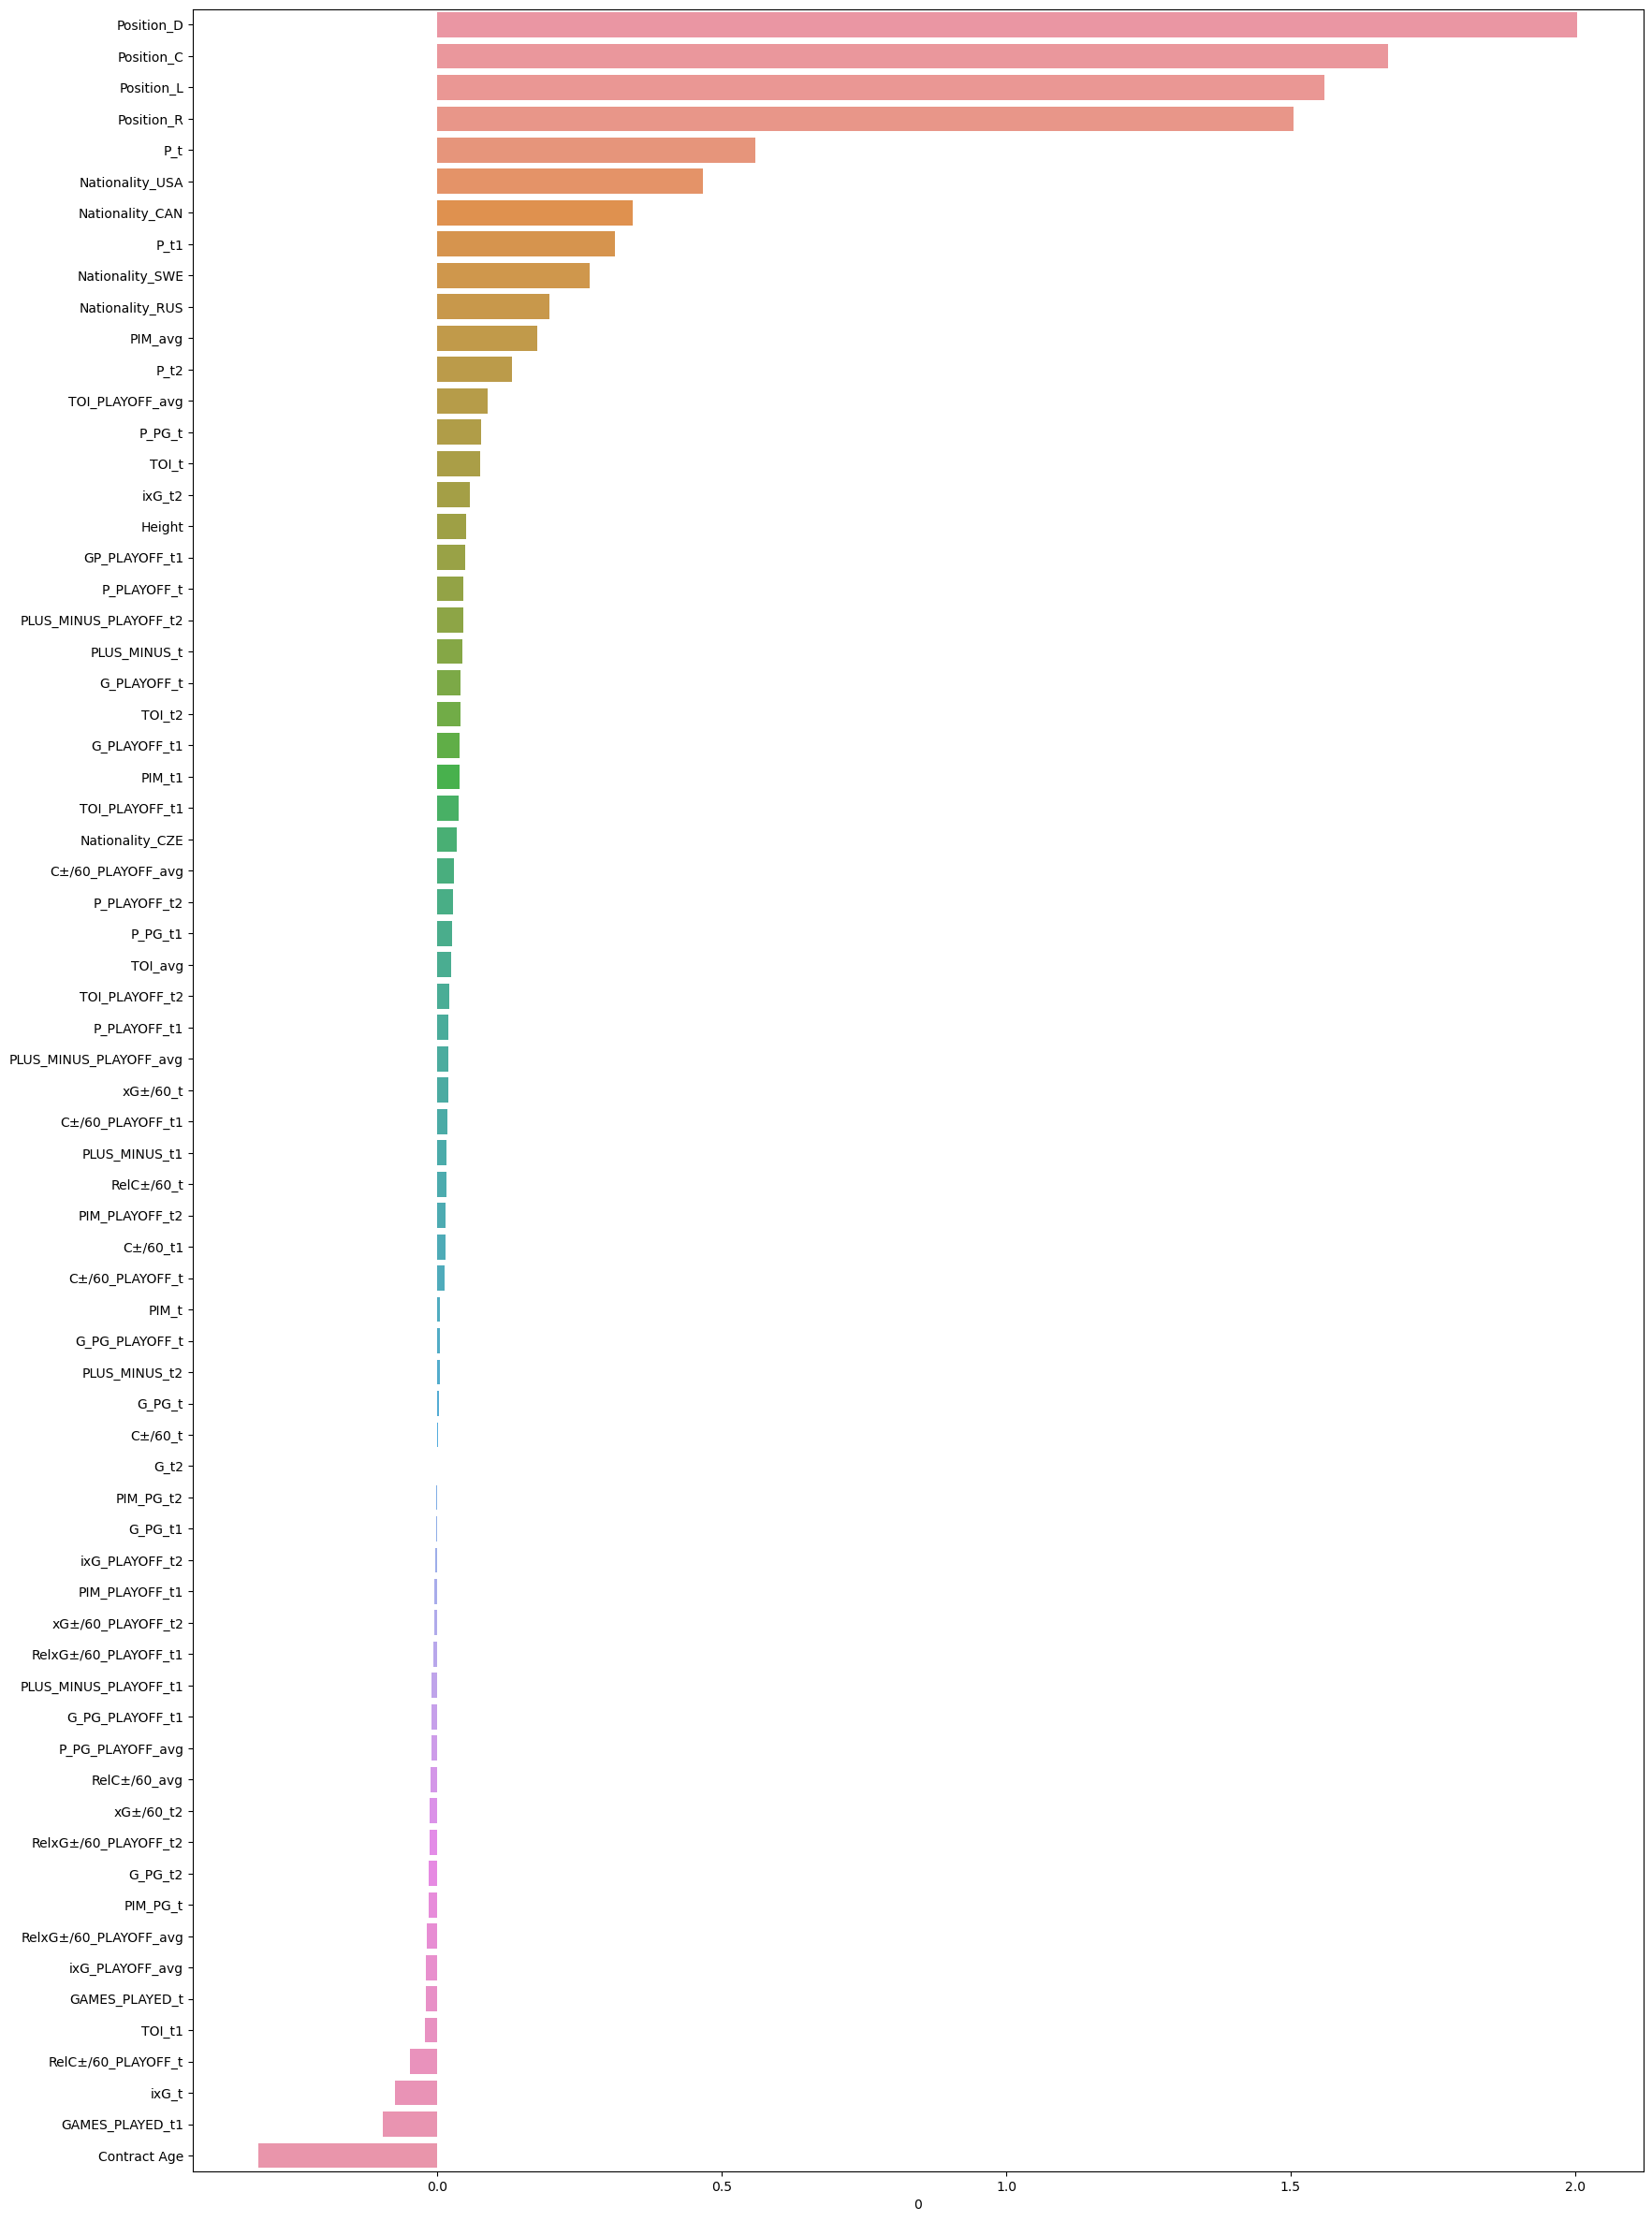

In [127]:
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=eln_l_coef_sub.index,x=eln_l_coef_sub[0]);

Looking at the coefficients in the elastic net model, compared to those in the LASSO model, several of the coefficients seem to overlap in ranked terms, with player positions being the most important in terms of the length of contract. Interestingly, several player nationalities were deemed more important in the elastic net model compared to the LASSO and ridge models.

### Decision Tree Regression

In [131]:
dtr_l = DecisionTreeRegressor(random_state=42)
dtr_l_parameters_1 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                      'splitter': ['best','random'],
                      'max_depth':[1,5,10,20],
                      'min_samples_split':[1,3,5,7],
                      'max_features':['auto','sqrt','log2']}
gs_dtr_l_1 = GridSearchCV(dtr_l,dtr_l_parameters_1,scoring='neg_mean_absolute_error',cv=5)
gs_dtr_l_1.fit(X,y_l)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5, 7],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error')

In [132]:
gs_dtr_l_1.best_score_

-0.7741737146977903

In [133]:
gs_dtr_l_1.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 7,
 'splitter': 'best'}

In [134]:
dtr_l_parameters_2 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                      'splitter': ['best'],
                      'max_depth':[1,5,10],
                      'min_samples_split':[5,7,10,12],
                      'max_features':['auto','sqrt','log2']}
gs_dtr_l_2 = GridSearchCV(dtr_l,dtr_l_parameters_2,scoring='neg_mean_absolute_error',cv=5)
gs_dtr_l_2.fit(X,y_l)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [5, 7, 10, 12],
                         'splitter': ['best']},
             scoring='neg_mean_absolute_error')

In [135]:
gs_dtr_l_2.best_score_

-0.7741737146977903

In [136]:
gs_dtr_l_2.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 7,
 'splitter': 'best'}

In [138]:
dtr_l_final = DecisionTreeRegressor(criterion = 'absolute_error',
                                    max_depth = 5,
                                    max_features = 'auto',
                                    min_samples_split = 7,
                                    splitter = 'best',
                                    random_state = 42)
dtr_l_final.fit(X,y_l)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features='auto', min_samples_split=7,
                      random_state=42)

In [139]:
mean_absolute_error(dtr_l_final.predict(X),y_l)

0.7059865391427559

In [144]:
dtr_l_featureImportances = pd.DataFrame(pd.Series(dtr_l_final.feature_importances_,index=dtr_l_final.feature_names_in_))
dtr_l_featureImportances_sub = dtr_l_featureImportances[dtr_l_featureImportances[0] != 0].sort_values(by=0,ascending=False)

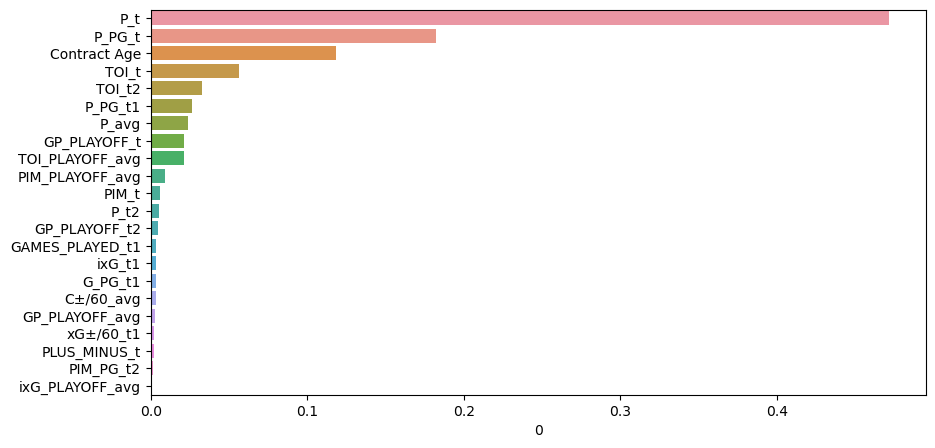

In [149]:
fig,ax = plt.subplots(figsize=(10,5))
sns.barplot(y=dtr_l_featureImportances_sub.index,x=dtr_l_featureImportances_sub[0]);

### XGBoost Regression

In [152]:
xgbr_l = XGBRegressor(random_state=42)
xgbr_l_parameters_1 = {'learning_rate': [0.05, 0.10, 0.15],
                       'max_depth': [2,5,10],
                       'min_child_weight': [1,3,5],
                       'n_estimators': [20,40,80],
                       'tree_method': ['exact','approx','hist']}

In [159]:
gs_xgrb_l_1 = GridSearchCV(xgbr_l,xgbr_l_parameters_1,scoring='neg_mean_absolute_error',cv=5)
gs_xgrb_l_1.fit(X,y_l)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [20, 40, 80],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error')

In [160]:
gs_xgrb_l_1.best_score_

-0.7861671466582278

In [161]:
gs_xgrb_l_1.best_params_

{'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 40,
 'tree_method': 'exact'}

In [162]:
xgbr_l_parameters_2 = {'learning_rate': [0.01,0.05,0.10,],
                       'max_depth': [5,10,15],
                       'min_child_weight': [3,5,10],
                       'n_estimators': [30,40,70],
                       'tree_method': ['exact','approx','hist']}

In [163]:
gs_xgrb_l_2 = GridSearchCV(xgbr_l,xgbr_l_parameters_2,scoring='neg_mean_absolute_error',cv=5)
gs_xgrb_l_2.fit(X,y_l)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 15],
                         'min_child_weight': [3, 5, 10],
                         'n_estimators': [30, 40, 70],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error')

In [164]:
gs_xgrb_l_2.best_score_

-0.7833354046889387

In [165]:
gs_xgrb_l_2.best_params_

{'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 10,
 'n_estimators': 40,
 'tree_method': 'exact'}

## Artificial Neural Networks

In [178]:
svr_l = SVR()
svr_l_parameters_1 = {'kernel':['linear','poly','rbf','sigmoid'],
                      'degree':[1,3,5],
                      'gamma':['scale','auto'],
                      'epsilon':[0.1,0.2,0.3],
                      'shrinking':[True,False]}

In [179]:
gs_svr_l_1 = GridSearchCV(svr_l,svr_l_parameters_1,cv=5,verbose=False)
gs_svr_l_1.fit(X,y_l)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'degree': [1, 3, 5], 'epsilon': [0.1, 0.2, 0.3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]},
             verbose=False)